# Predictive Analytics for Demand Forecasting (ERP/SAP Context)

## Business Problem
This project addresses a critical ERP-driven supply chain challenge where inaccurate demand forecasting leads to:
- **Excess Inventory**: Tying up capital and increasing holding costs
- **Stockouts**: Lost sales and customer dissatisfaction
- **Inefficient Planning**: Poor procurement and production scheduling

**Stakeholders**: Supply Chain Managers, Procurement Team, Plant Managers, Finance

**Objective**: Develop predictive models to improve demand forecast accuracy by 20-30%, enabling SAP MRP to optimize inventory levels and reduce planning errors.

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Time series libraries
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

## Step 2: Dataset Design & Synthetic Data Generation

Creating an ERP-style dataset that simulates SAP supply chain tables:
- **Material ID**: Similar to SAP MARA (Material Master)
- **Plant**: Similar to SAP T001W (Plant Master)
- **Date**: Transaction date
- **Sales Quantity**: Actual demand (VBRK/VBRP - Sales Documents)
- **Inventory Level**: Stock on hand (MARD - Storage Location Data)
- **Lead Time**: Procurement lead time days
- **Unit Price**: Material cost
- **Promotion**: Marketing campaign indicator

In [35]:
def generate_erp_demand_data(start_date='2021-01-01', end_date='2024-12-31', n_materials=5, n_plants=3):
    """
    Generate synthetic ERP demand data with realistic patterns:
    - Trend component
    - Seasonal patterns (yearly, monthly, weekly)
    - Random noise
    - Promotional spikes
    - Different characteristics per material/plant combination
    """
    
    # Date range
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    
    # Material and Plant definitions
    materials = [f'MAT{str(i).zfill(4)}' for i in range(1, n_materials + 1)]
    plants = [f'P{str(i).zfill(3)}' for i in range(1, n_plants + 1)]
    
    data_list = []
    
    for material in materials:
        for plant in plants:
            # Generate unique characteristics for each material-plant combination
            np.random.seed(hash(material + plant) % 2**32)
            
            # Base demand level (different for each material-plant)
            base_demand = np.random.randint(50, 300)
            
            # Trend component (some growing, some stable, some declining)
            trend_type = np.random.choice(['growing', 'stable', 'declining'])
            if trend_type == 'growing':
                trend = np.linspace(0, base_demand * 0.3, len(date_range))
            elif trend_type == 'declining':
                trend = np.linspace(0, -base_demand * 0.2, len(date_range))
            else:
                trend = np.zeros(len(date_range))
            
            # Seasonal components
            day_of_year = date_range.dayofyear
            yearly_seasonality = base_demand * 0.2 * np.sin(2 * np.pi * day_of_year / 365.25)
            
            # Weekly pattern (weekends lower)
            day_of_week = date_range.dayofweek
            weekly_pattern = np.where((day_of_week == 5) | (day_of_week == 6), 
                                     -base_demand * 0.15, base_demand * 0.05)
            
            # Random noise
            noise = np.random.normal(0, base_demand * 0.1, len(date_range))
            
            # Promotional spikes (random 5-7 day periods throughout the year)
            promotion = np.zeros(len(date_range))
            n_promotions = np.random.randint(6, 12)  # 6-12 promotions per year
            for _ in range(n_promotions):
                promo_start = np.random.randint(0, len(date_range) - 7)
                promo_duration = np.random.randint(5, 8)
                promotion[promo_start:promo_start + promo_duration] = base_demand * np.random.uniform(0.3, 0.6)
            
            # Combine all components
            demand = base_demand + trend + yearly_seasonality + weekly_pattern + noise + promotion
            demand = np.maximum(demand, 0)  # No negative demand
            demand = np.round(demand).astype(int)
            
            # Lead time (varies by material)
            lead_time = np.random.randint(5, 21, len(date_range))
            
            # Unit price (with some variation)
            base_price = np.random.uniform(10, 500)
            unit_price = base_price * (1 + np.random.normal(0, 0.05, len(date_range)))
            unit_price = np.maximum(unit_price, base_price * 0.8)
            
            # Inventory level (rough calculation: previous inventory + replenishment - demand)
            inventory = np.zeros(len(date_range))
            inventory[0] = base_demand * 30  # Start with ~30 days of stock
            
            for i in range(1, len(date_range)):
                # Simulate periodic replenishment (every 7-14 days)
                if i % np.random.randint(7, 15) == 0:
                    replenishment = base_demand * np.random.randint(20, 40)
                else:
                    replenishment = 0
                
                inventory[i] = max(0, inventory[i-1] + replenishment - demand[i-1])
            
            # Create promotion flag
            is_promotion = (promotion > 0).astype(int)
            
            # Build dataframe for this material-plant combination
            temp_df = pd.DataFrame({
                'Date': date_range,
                'Material_ID': material,
                'Plant': plant,
                'Sales_Quantity': demand,
                'Inventory_Level': inventory.astype(int),
                'Lead_Time_Days': lead_time,
                'Unit_Price': np.round(unit_price, 2),
                'Promotion_Flag': is_promotion
            })
            
            data_list.append(temp_df)
    
    # Combine all data
    df = pd.concat(data_list, ignore_index=True)
    
    # Add additional SAP-style fields
    df['Revenue'] = df['Sales_Quantity'] * df['Unit_Price']
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Quarter'] = df['Date'].dt.quarter
    df['Day_of_Week'] = df['Date'].dt.dayofweek
    df['Week_of_Year'] = df['Date'].dt.isocalendar().week
    
    # Introduce some realistic missing values (2-3%)
    missing_indices = np.random.choice(df.index, size=int(len(df) * 0.025), replace=False)
    df.loc[missing_indices, 'Sales_Quantity'] = np.nan
    
    return df

# Generate the dataset
print("Generating synthetic ERP demand data...")
print(f"Dataset created: {len(df_raw):,} records")
print(f"Date range: {df_raw['Date'].min()} to {df_raw['Date'].max()}")
print(f"Materials: {df_raw['Material_ID'].nunique()}")
print(f"Plants: {df_raw['Plant'].nunique()}")
print(f"\nDataset shape: {df_raw.shape}")
try:
    import openpyxl
    excel_available = True
except ImportError:
    excel_available = False
    print("\n⚠️  openpyxl not installed. Installing now...")
    import subprocess
    import sys
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "openpyxl"])
        import openpyxl
        excel_available = True
        print("✓ openpyxl installed successfully!")
    except:
        print("❌ Could not install openpyxl automatically.")
        print("   Please run: pip install openpyxl")
        excel_available = False

# Export to Excel with multiple sheets
if excel_available:
    excel_filename = 'C:\Users\menon\demand-forecasting-structure-ERP/outputs/SAP_ERP_Demand_forecast.xlsx'
with pd.ExcelWriter(excel_filename, engine='openpyxl') as writer:
    # Sheet 1: Raw CGM Data (sample - first 10,000 rows)
    df_export = df_raw.head(21915).copy()
    df_export.to_excel(writer, sheet_name='Demand_SAP_Data', index=False)

Generating synthetic ERP demand data...
Dataset created: 21,915 records
Date range: 2021-01-01 00:00:00 to 2024-12-31 00:00:00
Materials: 5
Plants: 3

Dataset shape: (21915, 14)


In [36]:
# Display sample data
print("\n=== Sample Data ===")
display(df_raw.head(10))

print("\n=== Data Types ===")
print(df_raw.dtypes)

print("\n=== Basic Statistics ===")
display(df_raw.describe())


=== Sample Data ===


,Date,Material_ID,Plant,Sales_Quantity,Inventory_Level,Lead_Time_Days,Unit_Price,Promotion_Flag,Revenue,Year,Month,Quarter,Day_of_Week,Week_of_Year
0,2021-01-01,MAT0001,P001,309.0,7980,6,322.16,0,99547.44,2021,1,1,4,53
1,2021-01-02,MAT0001,P001,208.0,7671,9,299.31,0,62256.48,2021,1,1,5,53
2,2021-01-03,MAT0001,P001,252.0,7463,13,354.12,0,89238.24,2021,1,1,6,53
3,2021-01-04,MAT0001,P001,295.0,7211,17,323.70,0,95491.50,2021,1,1,0,1
4,2021-01-05,MAT0001,P001,NaN,6916,13,317.96,0,100475.36,2021,1,1,1,1
5,2021-01-06,MAT0001,P001,304.0,6600,13,317.52,0,96526.08,2021,1,1,2,1
6,2021-01-07,MAT0001,P001,267.0,6296,5,300.09,0,80124.03,2021,1,1,3,1
7,2021-01-08,MAT0001,P001,242.0,6029,18,320.82,0,77638.44,2021,1,1,4,1
8,2021-01-09,MAT0001,P001,184.0,5787,16,298.85,0,54988.40,2021,1,1,5,1
9,2021-01-10,MAT0001,P001,222.0,11455,11,322.16,0,71519.52,2021,1,1,6,1



=== Data Types ===
Date               datetime64[ns]
Material_ID                object
Plant                      object
Sales_Quantity            float64
Inventory_Level             int64
Lead_Time_Days              int32
Unit_Price                float64
Promotion_Flag              int64
Revenue                   float64
Year                        int32
Month                       int32
Quarter                     int32
Day_of_Week                 int32
Week_of_Year               UInt32
dtype: object

=== Basic Statistics ===


,Date,Sales_Quantity,Inventory_Level,Lead_Time_Days,Unit_Price,Promotion_Flag,Revenue,Year,Month,Quarter,Day_of_Week,Week_of_Year
count,21915,21368.000000,21915.000000,21915.000000,21915.000000,21915.000000,21915.000000,21915.000000,21915.000000,21915.000000,21915.000000,21915.0
mean,2022-12-31 23:59:59.999999744,183.512542,274173.638969,12.526854,256.390114,0.032170,47251.252397,2022.501027,6.522930,2.508556,3.000684,26.519507
min,2021-01-01 00:00:00,20.000000,0.000000,5.000000,19.120000,0.000000,1369.980000,2021.000000,1.000000,1.000000,0.000000,1.0
25%,2022-01-01 00:00:00,129.000000,122200.000000,9.000000,82.810000,0.000000,14038.480000,2022.000000,4.000000,2.000000,1.000000,13.0
50%,2023-01-01 00:00:00,178.000000,244483.000000,13.000000,282.220000,0.000000,46775.000000,2023.000000,7.000000,3.000000,3.000000,27.0
75%,2024-01-01 00:00:00,235.000000,398863.500000,17.000000,383.955000,0.000000,69140.560000,2024.000000,10.000000,4.000000,5.000000,40.0
max,2024-12-31 00:00:00,569.000000,943284.000000,20.000000,552.000000,1.000000,228256.280000,2024.000000,12.000000,4.000000,6.000000,53.0
std,NaN,73.982624,188724.762093,4.604654,154.002289,0.176455,34673.635242,1.118365,3.448782,1.117108,2.001243,15.060585


## Step 3: Data Cleaning & Preprocessing

Handle missing values, outliers, and prepare data for time series forecasting.

In [7]:
# Create a copy for preprocessing
df = df_raw.copy()

print("=== Data Quality Check ===")
print(f"\nMissing Values:")
print(df.isnull().sum())

print(f"\nMissing percentage: {(df['Sales_Quantity'].isnull().sum() / len(df)) * 100:.2f}%")

# Handle missing values with forward fill then backward fill
print("\nHandling missing values using forward fill method...")
df['Sales_Quantity'].fillna(method='ffill', inplace=True)
df['Sales_Quantity'].fillna(method='bfill', inplace=True)

# Verify no missing values remain
print(f"Missing values after imputation: {df['Sales_Quantity'].isnull().sum()}")

# Detect and handle outliers using IQR method
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR  # Using 3*IQR for more lenient outlier detection
    upper_bound = Q3 + 3 * IQR
    
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

print("\n=== Outlier Detection ===")
outliers, lower, upper = detect_outliers_iqr(df, 'Sales_Quantity')
print(f"Outliers detected: {len(outliers)} ({(len(outliers)/len(df))*100:.2f}%)")
print(f"Bounds: [{lower:.2f}, {upper:.2f}]")

# Cap outliers instead of removing them (more conservative approach)
df['Sales_Quantity'] = df['Sales_Quantity'].clip(lower=lower, upper=upper)

print("\nOutliers capped to IQR bounds.")

=== Data Quality Check ===

Missing Values:
Date                 0
Material_ID          0
Plant                0
Sales_Quantity     547
Inventory_Level      0
Lead_Time_Days       0
Unit_Price           0
Promotion_Flag       0
Revenue              0
Year                 0
Month                0
Quarter              0
Day_of_Week          0
Week_of_Year         0
dtype: int64

Missing percentage: 2.50%

Handling missing values using forward fill method...
Missing values after imputation: 0

=== Outlier Detection ===
Outliers detected: 1 (0.00%)
Bounds: [-189.00, 553.00]

Outliers capped to IQR bounds.


In [8]:
# Feature Engineering for Time Series
print("\n=== Feature Engineering ===")

# Create lag features
def create_lag_features(data, column, lags=[1, 7, 14, 30]):
    """Create lag features for time series"""
    df_temp = data.copy()
    for lag in lags:
        df_temp[f'{column}_lag_{lag}'] = df_temp.groupby(['Material_ID', 'Plant'])[column].shift(lag)
    return df_temp

# Create rolling window features
def create_rolling_features(data, column, windows=[7, 14, 30]):
    """Create rolling mean and std features"""
    df_temp = data.copy()
    for window in windows:
        df_temp[f'{column}_rolling_mean_{window}'] = df_temp.groupby(['Material_ID', 'Plant'])[column].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean()
        )
        df_temp[f'{column}_rolling_std_{window}'] = df_temp.groupby(['Material_ID', 'Plant'])[column].transform(
            lambda x: x.rolling(window=window, min_periods=1).std()
        )
    return df_temp

# Apply feature engineering
print("Creating lag features...")
df = create_lag_features(df, 'Sales_Quantity', lags=[1, 7, 14, 30])

print("Creating rolling window features...")
df = create_rolling_features(df, 'Sales_Quantity', windows=[7, 14, 30])

# Create additional time-based features
df['Is_Weekend'] = df['Day_of_Week'].isin([5, 6]).astype(int)
df['Is_Month_Start'] = df['Date'].dt.is_month_start.astype(int)
df['Is_Month_End'] = df['Date'].dt.is_month_end.astype(int)
df['Days_In_Month'] = df['Date'].dt.days_in_month

print(f"\nFeatures created. New shape: {df.shape}")
print(f"\nNew columns:")
new_cols = [col for col in df.columns if 'lag' in col or 'rolling' in col or 'Is_' in col]
print(new_cols)


=== Feature Engineering ===
Creating lag features...
Creating rolling window features...

Features created. New shape: (21915, 28)

New columns:
['Promotion_Flag', 'Sales_Quantity_lag_1', 'Sales_Quantity_lag_7', 'Sales_Quantity_lag_14', 'Sales_Quantity_lag_30', 'Sales_Quantity_rolling_mean_7', 'Sales_Quantity_rolling_std_7', 'Sales_Quantity_rolling_mean_14', 'Sales_Quantity_rolling_std_14', 'Sales_Quantity_rolling_mean_30', 'Sales_Quantity_rolling_std_30', 'Is_Weekend', 'Is_Month_Start', 'Is_Month_End']


## Step 4: Exploratory Data Analysis (EDA)

Analyze trends, seasonality, and demand variability to understand patterns that impact SAP MRP planning.

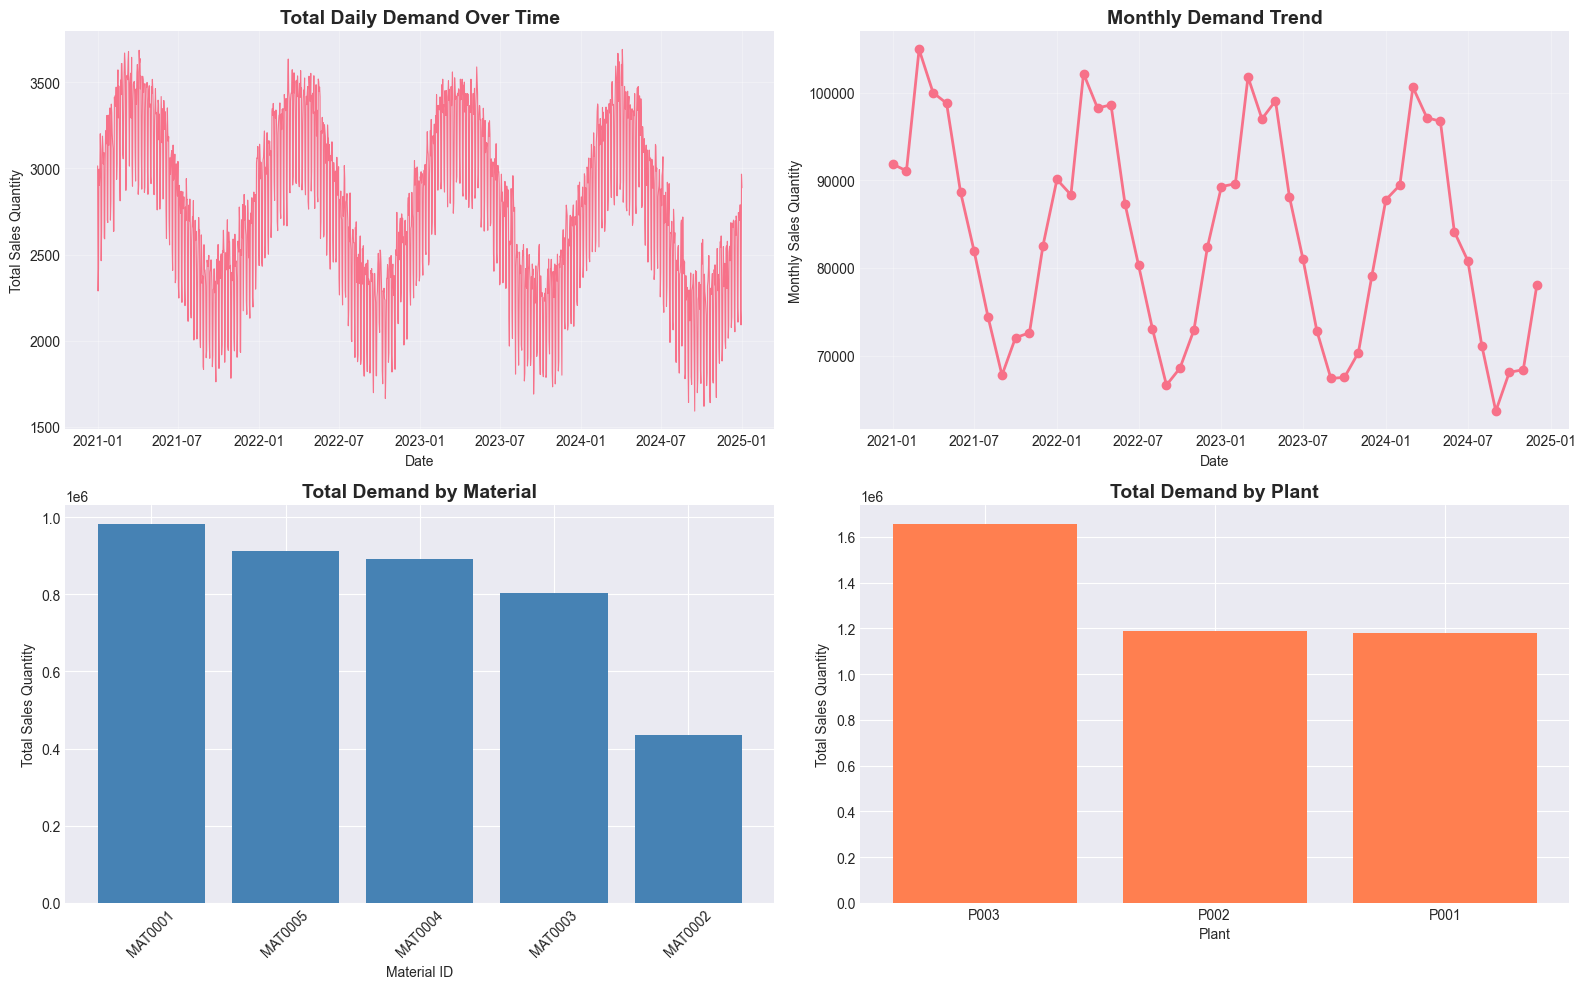


=== Demand Summary Statistics ===
Total demand (all materials, all plants): 4,024,661 units
Average daily demand: 2,755 units
Peak daily demand: 3,692 units
Minimum daily demand: 1,590 units


In [12]:
# Overall demand trend
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Total daily demand over time
daily_demand = df.groupby('Date')['Sales_Quantity'].sum().reset_index()
axes[0, 0].plot(daily_demand['Date'], daily_demand['Sales_Quantity'], linewidth=0.8)
axes[0, 0].set_title('Total Daily Demand Over Time', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Total Sales Quantity')
axes[0, 0].grid(True, alpha=0.3)

# 2. Monthly demand aggregation
monthly_demand = df.groupby(['Year', 'Month'])['Sales_Quantity'].sum().reset_index()
monthly_demand['Date'] = pd.to_datetime(monthly_demand[['Year', 'Month']].assign(Day=1))
axes[0, 1].plot(monthly_demand['Date'], monthly_demand['Sales_Quantity'], marker='o', linewidth=2)
axes[0, 1].set_title('Monthly Demand Trend', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Monthly Sales Quantity')
axes[0, 1].grid(True, alpha=0.3)

# 3. Demand by Material
material_demand = df.groupby('Material_ID')['Sales_Quantity'].sum().sort_values(ascending=False)
axes[1, 0].bar(material_demand.index, material_demand.values, color='steelblue')
axes[1, 0].set_title('Total Demand by Material', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Material ID')
axes[1, 0].set_ylabel('Total Sales Quantity')
axes[1, 0].tick_params(axis='x', rotation=45)

# 4. Demand by Plant
plant_demand = df.groupby('Plant')['Sales_Quantity'].sum().sort_values(ascending=False)
axes[1, 1].bar(plant_demand.index, plant_demand.values, color='coral')
axes[1, 1].set_title('Total Demand by Plant', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Plant')
axes[1, 1].set_ylabel('Total Sales Quantity')

plt.tight_layout()
plt.savefig('C:/Users/menon/demand-forecasting-structure-ERP/outputs/demand_overview.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n=== Demand Summary Statistics ===")
print(f"Total demand (all materials, all plants): {df['Sales_Quantity'].sum():,.0f} units")
print(f"Average daily demand: {df.groupby('Date')['Sales_Quantity'].sum().mean():,.0f} units")
print(f"Peak daily demand: {df.groupby('Date')['Sales_Quantity'].sum().max():,.0f} units")
print(f"Minimum daily demand: {df.groupby('Date')['Sales_Quantity'].sum().min():,.0f} units")

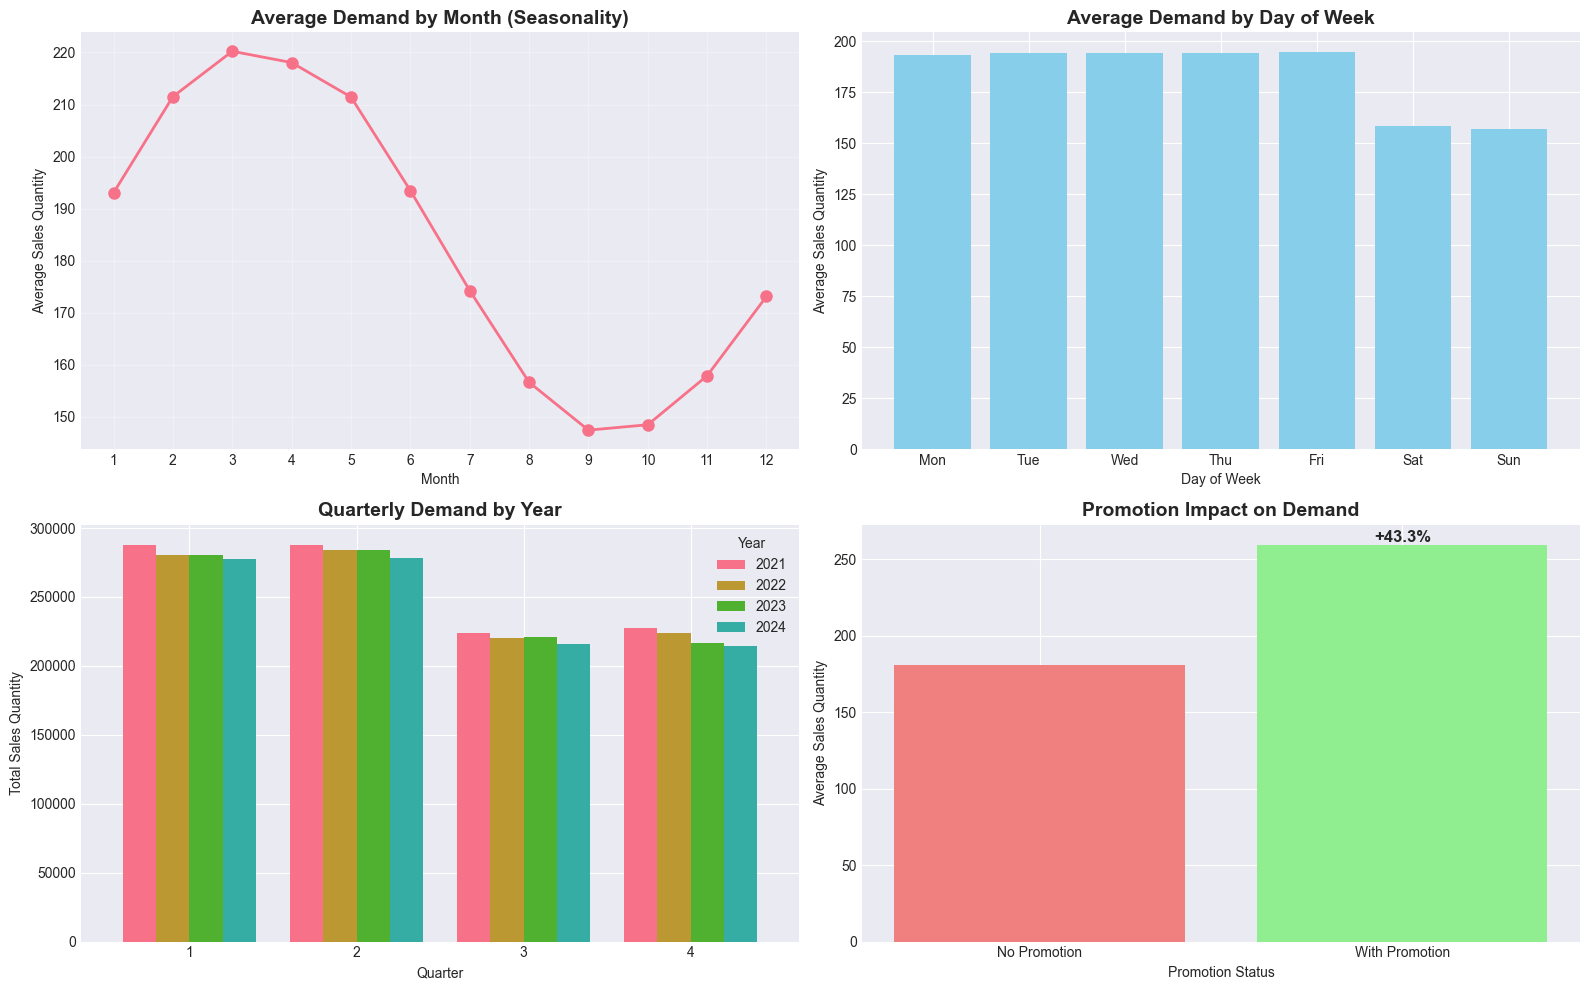


Promotion Impact: Average demand increases by 43.3% during promotions


In [13]:
# Seasonality Analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Monthly seasonality
monthly_avg = df.groupby('Month')['Sales_Quantity'].mean()
axes[0, 0].plot(monthly_avg.index, monthly_avg.values, marker='o', linewidth=2, markersize=8)
axes[0, 0].set_title('Average Demand by Month (Seasonality)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Average Sales Quantity')
axes[0, 0].set_xticks(range(1, 13))
axes[0, 0].grid(True, alpha=0.3)

# 2. Day of week pattern
dow_avg = df.groupby('Day_of_Week')['Sales_Quantity'].mean()
dow_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[0, 1].bar(range(7), dow_avg.values, color='skyblue')
axes[0, 1].set_title('Average Demand by Day of Week', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Day of Week')
axes[0, 1].set_ylabel('Average Sales Quantity')
axes[0, 1].set_xticks(range(7))
axes[0, 1].set_xticklabels(dow_labels)

# 3. Quarter comparison
quarterly_demand = df.groupby(['Year', 'Quarter'])['Sales_Quantity'].sum().reset_index()
quarterly_pivot = quarterly_demand.pivot(index='Quarter', columns='Year', values='Sales_Quantity')
quarterly_pivot.plot(kind='bar', ax=axes[1, 0], width=0.8)
axes[1, 0].set_title('Quarterly Demand by Year', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Quarter')
axes[1, 0].set_ylabel('Total Sales Quantity')
axes[1, 0].legend(title='Year')
axes[1, 0].tick_params(axis='x', rotation=0)

# 4. Promotion impact
promo_comparison = df.groupby('Promotion_Flag')['Sales_Quantity'].mean()
axes[1, 1].bar(['No Promotion', 'With Promotion'], promo_comparison.values, color=['lightcoral', 'lightgreen'])
axes[1, 1].set_title('Promotion Impact on Demand', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Average Sales Quantity')
axes[1, 1].set_xlabel('Promotion Status')

# Add percentage increase text
pct_increase = ((promo_comparison[1] - promo_comparison[0]) / promo_comparison[0]) * 100
axes[1, 1].text(1, promo_comparison[1], f'+{pct_increase:.1f}%', 
                ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('C:/Users/menon/demand-forecasting-structure-ERP/outputs/seasonality_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nPromotion Impact: Average demand increases by {pct_increase:.1f}% during promotions")

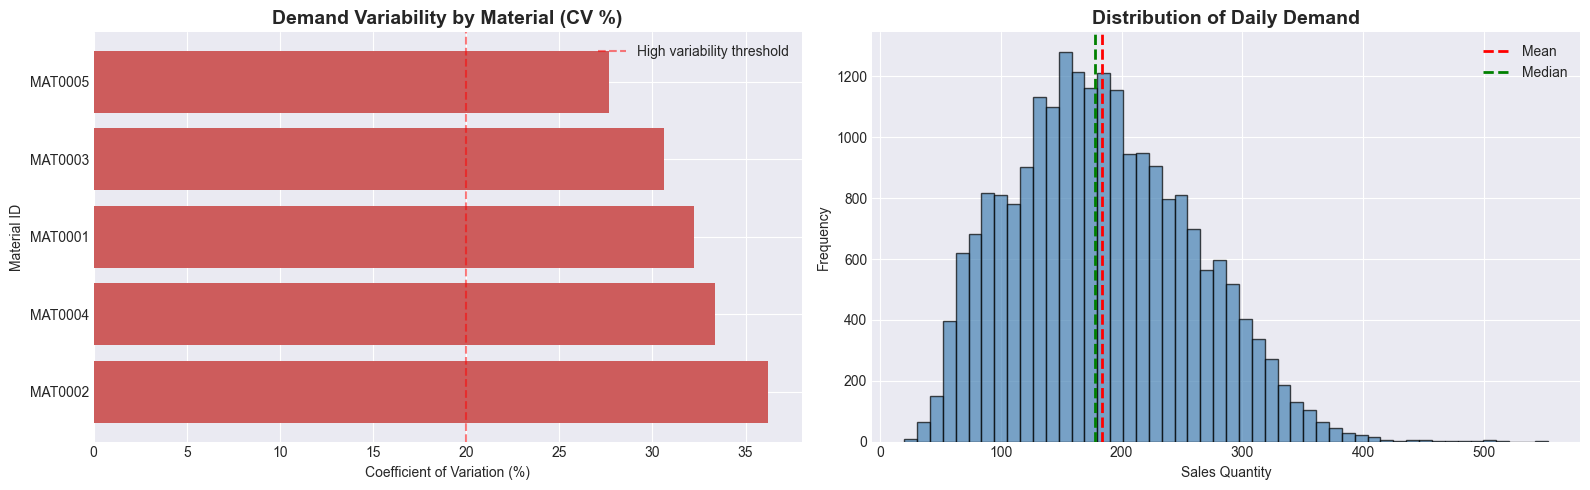


=== Demand Variability Insights ===
Materials with high variability (CV > 20%):
  MAT0002: CV = 36.2% - Requires higher safety stock
  MAT0004: CV = 33.4% - Requires higher safety stock
  MAT0001: CV = 32.2% - Requires higher safety stock
  MAT0003: CV = 30.6% - Requires higher safety stock
  MAT0005: CV = 27.6% - Requires higher safety stock


In [15]:
# Demand Variability Analysis
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Coefficient of Variation by Material
cv_by_material = df.groupby('Material_ID')['Sales_Quantity'].agg(['mean', 'std'])
cv_by_material['CV'] = (cv_by_material['std'] / cv_by_material['mean']) * 100
cv_by_material = cv_by_material.sort_values('CV', ascending=False)

axes[0].barh(cv_by_material.index, cv_by_material['CV'], color='indianred')
axes[0].set_title('Demand Variability by Material (CV %)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Coefficient of Variation (%)')
axes[0].set_ylabel('Material ID')
axes[0].axvline(x=20, color='red', linestyle='--', alpha=0.5, label='High variability threshold')
axes[0].legend()

# Distribution of daily demand
axes[1].hist(df['Sales_Quantity'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[1].set_title('Distribution of Daily Demand', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Sales Quantity')
axes[1].set_ylabel('Frequency')
axes[1].axvline(df['Sales_Quantity'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
axes[1].axvline(df['Sales_Quantity'].median(), color='green', linestyle='--', linewidth=2, label='Median')
axes[1].legend()

plt.tight_layout()
plt.savefig('C:/Users/menon/demand-forecasting-structure-ERP/outputs/variability_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n=== Demand Variability Insights ===")
print(f"Materials with high variability (CV > 20%):")
high_var = cv_by_material[cv_by_material['CV'] > 20]
for mat, row in high_var.iterrows():
    print(f"  {mat}: CV = {row['CV']:.1f}% - Requires higher safety stock")

Analyzing time series decomposition for: MAT0004 at P003


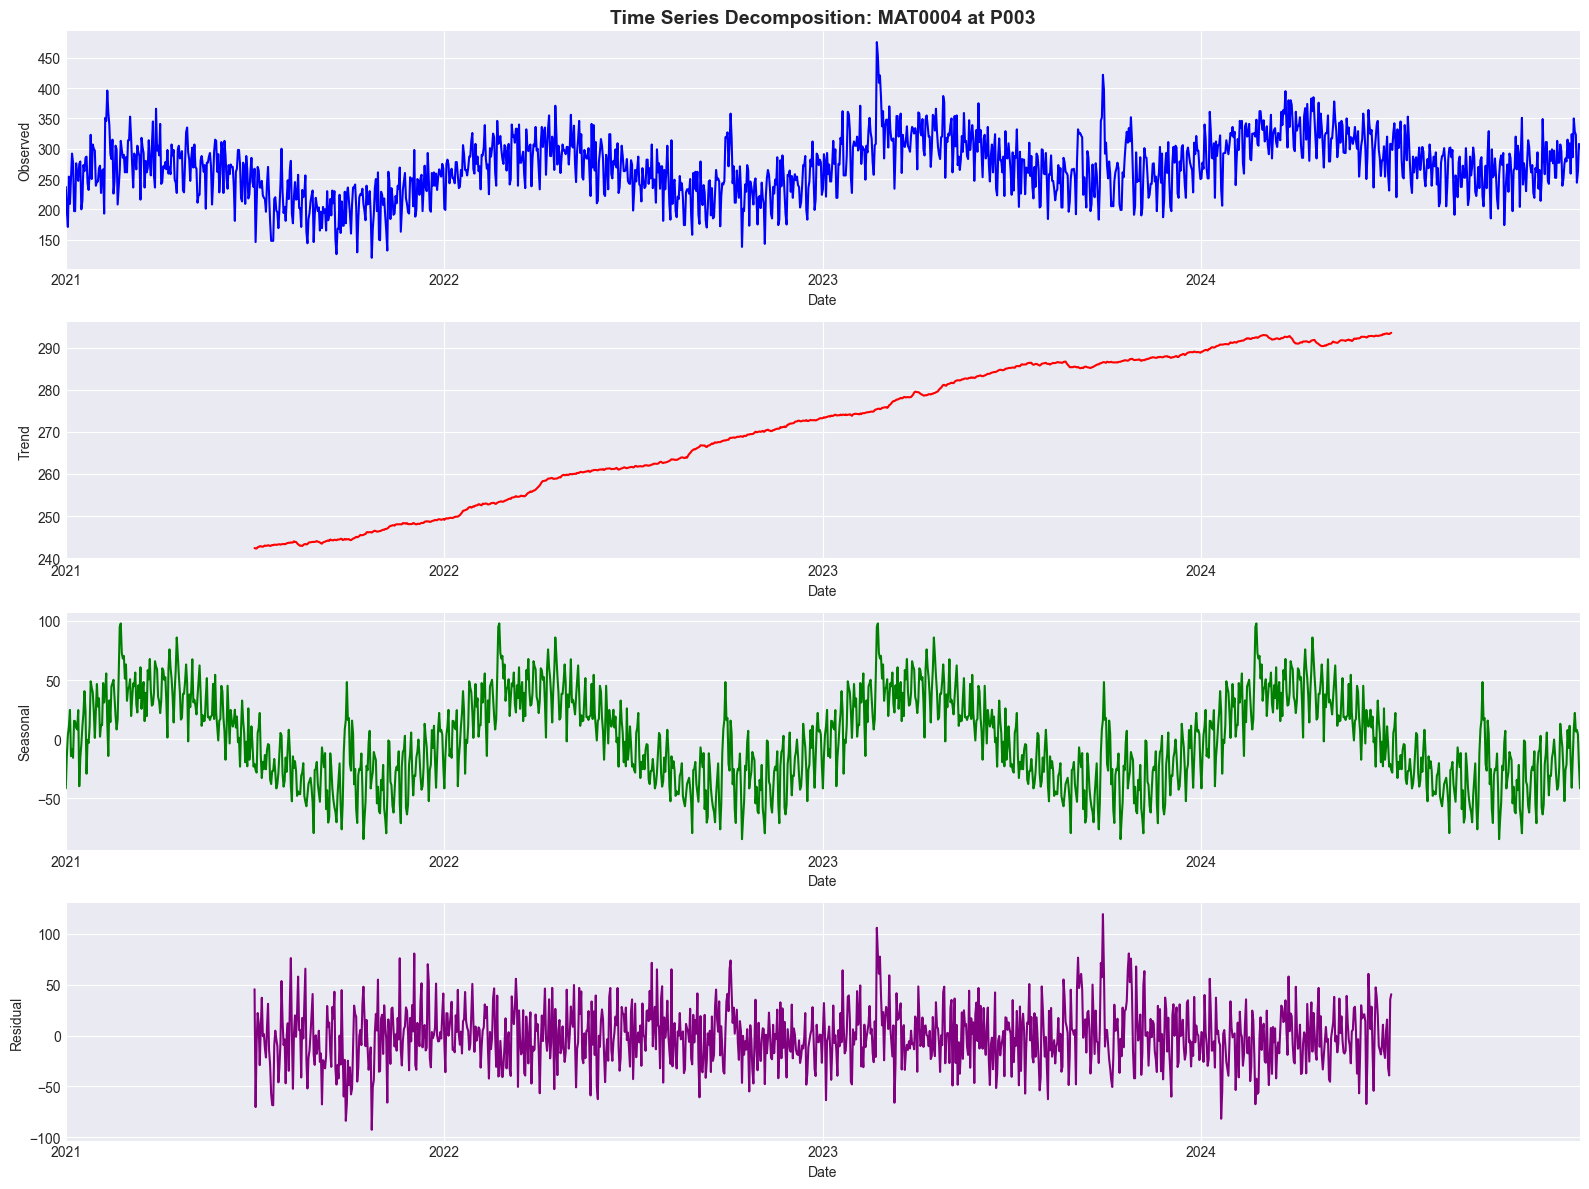


=== Impact on SAP MRP Planning ===
1. Strong seasonality detected → Adjust MRP parameters for peak/low seasons
2. Upward/downward trend identified → Update forecast models quarterly
3. High variability materials → Increase safety stock levels
4. Promotion impact significant → Include promotional calendar in planning


In [16]:
# Time Series Decomposition for a single material-plant combination
# Select the highest volume material-plant combination
material_plant_volumes = df.groupby(['Material_ID', 'Plant'])['Sales_Quantity'].sum().sort_values(ascending=False)
top_combo = material_plant_volumes.index[0]
print(f"Analyzing time series decomposition for: {top_combo[0]} at {top_combo[1]}")

# Filter data for this combination
ts_data = df[(df['Material_ID'] == top_combo[0]) & (df['Plant'] == top_combo[1])].copy()
ts_data = ts_data.set_index('Date')['Sales_Quantity'].asfreq('D')

# Perform decomposition
decomposition = seasonal_decompose(ts_data, model='additive', period=365)

# Plot decomposition
fig, axes = plt.subplots(4, 1, figsize=(16, 12))

decomposition.observed.plot(ax=axes[0], color='blue')
axes[0].set_ylabel('Observed')
axes[0].set_title(f'Time Series Decomposition: {top_combo[0]} at {top_combo[1]}', fontsize=14, fontweight='bold')

decomposition.trend.plot(ax=axes[1], color='red')
axes[1].set_ylabel('Trend')

decomposition.seasonal.plot(ax=axes[2], color='green')
axes[2].set_ylabel('Seasonal')

decomposition.resid.plot(ax=axes[3], color='purple')
axes[3].set_ylabel('Residual')
axes[3].set_xlabel('Date')

plt.tight_layout()
plt.savefig('C:/Users/menon/demand-forecasting-structure-ERP/outputs/time_series_decomposition.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n=== Impact on SAP MRP Planning ===")
print("1. Strong seasonality detected → Adjust MRP parameters for peak/low seasons")
print("2. Upward/downward trend identified → Update forecast models quarterly")
print("3. High variability materials → Increase safety stock levels")
print("4. Promotion impact significant → Include promotional calendar in planning")

## Step 5: Time Series Forecasting Models

Build and compare multiple forecasting models:
1. Moving Average (Baseline)
2. Exponential Smoothing (Holt-Winters)
3. ARIMA/SARIMA
4. Prophet (Facebook's forecasting tool)

In [17]:
# Prepare data for modeling - focus on top material-plant combination
model_data = df[(df['Material_ID'] == top_combo[0]) & (df['Plant'] == top_combo[1])].copy()
model_data = model_data.sort_values('Date').reset_index(drop=True)

# Split data: 80% training, 20% testing
split_point = int(len(model_data) * 0.8)
train_data = model_data.iloc[:split_point].copy()
test_data = model_data.iloc[split_point:].copy()

print(f"Training data: {len(train_data)} days ({train_data['Date'].min()} to {train_data['Date'].max()})")
print(f"Test data: {len(test_data)} days ({test_data['Date'].min()} to {test_data['Date'].max()})")

# Prepare series for modeling
train_series = train_data.set_index('Date')['Sales_Quantity']
test_series = test_data.set_index('Date')['Sales_Quantity']

Training data: 1168 days (2021-01-01 00:00:00 to 2024-03-13 00:00:00)
Test data: 293 days (2024-03-14 00:00:00 to 2024-12-31 00:00:00)


In [18]:
# Model 1: Moving Average (Baseline)
print("\n=== Model 1: Moving Average ===")

window_sizes = [7, 14, 30]
ma_predictions = {}

for window in window_sizes:
    # Calculate moving average
    ma = train_series.rolling(window=window).mean()
    last_ma = ma.iloc[-1]
    
    # Predict: use last MA value for all future points (naive approach)
    ma_pred = pd.Series([last_ma] * len(test_series), index=test_series.index)
    ma_predictions[f'MA_{window}'] = ma_pred
    
    print(f"MA-{window}: Last MA value = {last_ma:.2f}")

print("\nMoving Average models created.")


=== Model 1: Moving Average ===
MA-7: Last MA value = 322.86
MA-14: Last MA value = 321.50
MA-30: Last MA value = 323.73

Moving Average models created.


In [19]:
# Model 2: Exponential Smoothing (Holt-Winters)
print("\n=== Model 2: Holt-Winters Exponential Smoothing ===")

try:
    # Fit Holt-Winters model with additive seasonality
    hw_model = ExponentialSmoothing(
        train_series,
        seasonal_periods=365,  # Yearly seasonality
        trend='add',
        seasonal='add',
        damped_trend=True
    ).fit(optimized=True)
    
    # Forecast
    hw_predictions = hw_model.forecast(steps=len(test_series))
    hw_predictions.index = test_series.index
    
    print("Holt-Winters model fitted successfully")
    print(f"Parameters: alpha={hw_model.params['smoothing_level']:.4f}, "
          f"beta={hw_model.params['smoothing_trend']:.4f}, "
          f"gamma={hw_model.params['smoothing_seasonal']:.4f}")
    
except Exception as e:
    print(f"Holt-Winters fitting failed: {e}")
    # Fallback to simple exponential smoothing
    hw_model = ExponentialSmoothing(train_series, trend='add').fit()
    hw_predictions = hw_model.forecast(steps=len(test_series))
    hw_predictions.index = test_series.index
    print("Using Simple Exponential Smoothing as fallback")


=== Model 2: Holt-Winters Exponential Smoothing ===
Holt-Winters model fitted successfully
Parameters: alpha=0.2912, beta=0.0000, gamma=0.0000


In [20]:
# Model 3: SARIMA (Seasonal ARIMA)
print("\n=== Model 3: SARIMA ===")

# Use fixed parameters for efficiency (in production, use auto_arima)
# SARIMA(p,d,q)(P,D,Q,s) - (1,1,1)(1,1,1,52) for weekly seasonality
# Using weekly seasonality (52) instead of daily (365) for computational efficiency

try:
    sarima_model = SARIMAX(
        train_series,
        order=(1, 1, 1),  # (p, d, q)
        seasonal_order=(1, 1, 1, 52),  # (P, D, Q, s)
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False, maxiter=200)
    
    # Forecast
    sarima_predictions = sarima_model.forecast(steps=len(test_series))
    sarima_predictions.index = test_series.index
    
    print("SARIMA model fitted successfully")
    print(f"AIC: {sarima_model.aic:.2f}")
    print(f"BIC: {sarima_model.bic:.2f}")
    
except Exception as e:
    print(f"SARIMA fitting failed: {e}")
    # Fallback to simple ARIMA
    sarima_model = ARIMA(train_series, order=(1, 1, 1)).fit()
    sarima_predictions = sarima_model.forecast(steps=len(test_series))
    sarima_predictions.index = test_series.index
    print("Using ARIMA as fallback")


=== Model 3: SARIMA ===
SARIMA model fitted successfully
AIC: 10686.15
BIC: 10710.99


In [21]:
# Model 4: Prophet
print("\n=== Model 4: Prophet ===")

# Prepare data for Prophet (requires 'ds' and 'y' columns)
prophet_train = train_data[['Date', 'Sales_Quantity']].copy()
prophet_train.columns = ['ds', 'y']

# Add promotion as regressor
prophet_train['promotion'] = train_data['Promotion_Flag'].values

# Fit Prophet model
prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='additive',
    changepoint_prior_scale=0.05,  # Flexibility of trend
    seasonality_prior_scale=10.0    # Strength of seasonality
)

# Add promotion as extra regressor
prophet_model.add_regressor('promotion')

prophet_model.fit(prophet_train)

# Create future dataframe
prophet_future = test_data[['Date', 'Promotion_Flag']].copy()
prophet_future.columns = ['ds', 'promotion']

# Predict
prophet_forecast = prophet_model.predict(prophet_future)
prophet_predictions = pd.Series(
    prophet_forecast['yhat'].values,
    index=test_series.index
)

print("Prophet model fitted successfully")
print(f"Detected {len(prophet_model.changepoints)} changepoints in trend")


=== Model 4: Prophet ===


15:46:42 - cmdstanpy - INFO - Chain [1] start processing
15:46:43 - cmdstanpy - INFO - Chain [1] done processing


Prophet model fitted successfully
Detected 25 changepoints in trend


## Step 6: Model Evaluation

Compare models using MAE, RMSE, and MAPE metrics.

In [22]:
# Calculate evaluation metrics
def calculate_metrics(actual, predicted, model_name):
    """Calculate MAE, RMSE, and MAPE"""
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    
    return {
        'Model': model_name,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE (%)': mape
    }

# Evaluate all models
results = []

# Moving Average models
for ma_name, ma_pred in ma_predictions.items():
    results.append(calculate_metrics(test_series, ma_pred, ma_name))

# Holt-Winters
results.append(calculate_metrics(test_series, hw_predictions, 'Holt-Winters'))

# SARIMA
results.append(calculate_metrics(test_series, sarima_predictions, 'SARIMA'))

# Prophet
results.append(calculate_metrics(test_series, prophet_predictions, 'Prophet'))

# Create results dataframe
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('MAPE (%)')

print("\n=== Model Performance Comparison ===")
display(results_df)

# Find best model
best_model = results_df.iloc[0]['Model']
best_mape = results_df.iloc[0]['MAPE (%)']
baseline_mape = results_df[results_df['Model'] == 'MA_30']['MAPE (%)'].values[0]
improvement = baseline_mape - best_mape
improvement_pct = (improvement / baseline_mape) * 100

print(f"\n🏆 Best Model: {best_model}")
print(f"MAPE Improvement: {improvement:.2f} percentage points ({improvement_pct:.1f}% better than MA-30 baseline)")


=== Model Performance Comparison ===


,Model,MAE,RMSE,MAPE (%)
5,Prophet,19.948420,25.265917,6.881677
3,Holt-Winters,38.635074,46.980133,13.313307
1,MA_14,42.994881,52.746585,16.602317
0,MA_7,43.727938,53.569509,16.900409
2,MA_30,44.213424,54.112234,17.096645
4,SARIMA,45.999309,56.179080,17.736522



🏆 Best Model: Prophet
MAPE Improvement: 10.21 percentage points (59.7% better than MA-30 baseline)


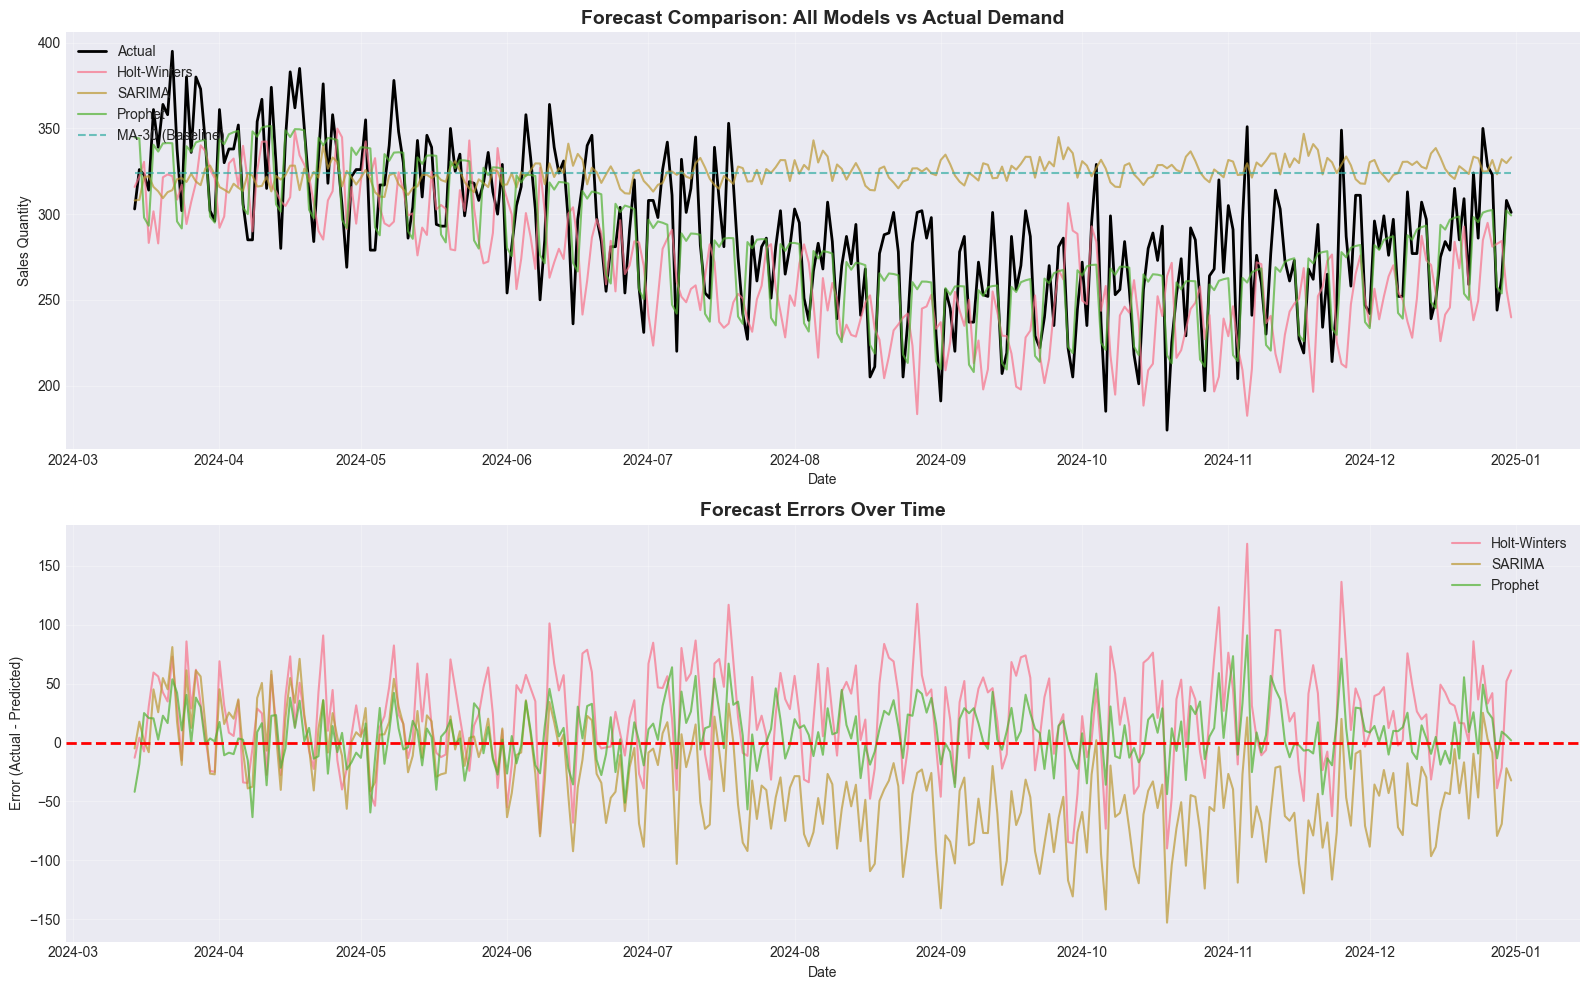

In [24]:
# Visualize model predictions vs actuals
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Plot 1: All predictions vs actual
axes[0].plot(test_series.index, test_series.values, label='Actual', linewidth=2, color='black')
axes[0].plot(test_series.index, hw_predictions.values, label='Holt-Winters', linewidth=1.5, alpha=0.7)
axes[0].plot(test_series.index, sarima_predictions.values, label='SARIMA', linewidth=1.5, alpha=0.7)
axes[0].plot(test_series.index, prophet_predictions.values, label='Prophet', linewidth=1.5, alpha=0.7)
axes[0].plot(test_series.index, ma_predictions['MA_30'].values, label='MA-30 (Baseline)', 
             linewidth=1.5, alpha=0.7, linestyle='--')

axes[0].set_title('Forecast Comparison: All Models vs Actual Demand', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Sales Quantity')
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.3)

# Plot 2: Error comparison
models_to_plot = ['Holt-Winters', 'SARIMA', 'Prophet']
errors = {}

errors['Holt-Winters'] = test_series.values - hw_predictions.values
errors['SARIMA'] = test_series.values - sarima_predictions.values
errors['Prophet'] = test_series.values - prophet_predictions.values

for model_name, error in errors.items():
    axes[1].plot(test_series.index, error, label=model_name, alpha=0.7)

axes[1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1].set_title('Forecast Errors Over Time', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Error (Actual - Predicted)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('C:/Users/menon/demand-forecasting-structure-ERP/outputs/forecast_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

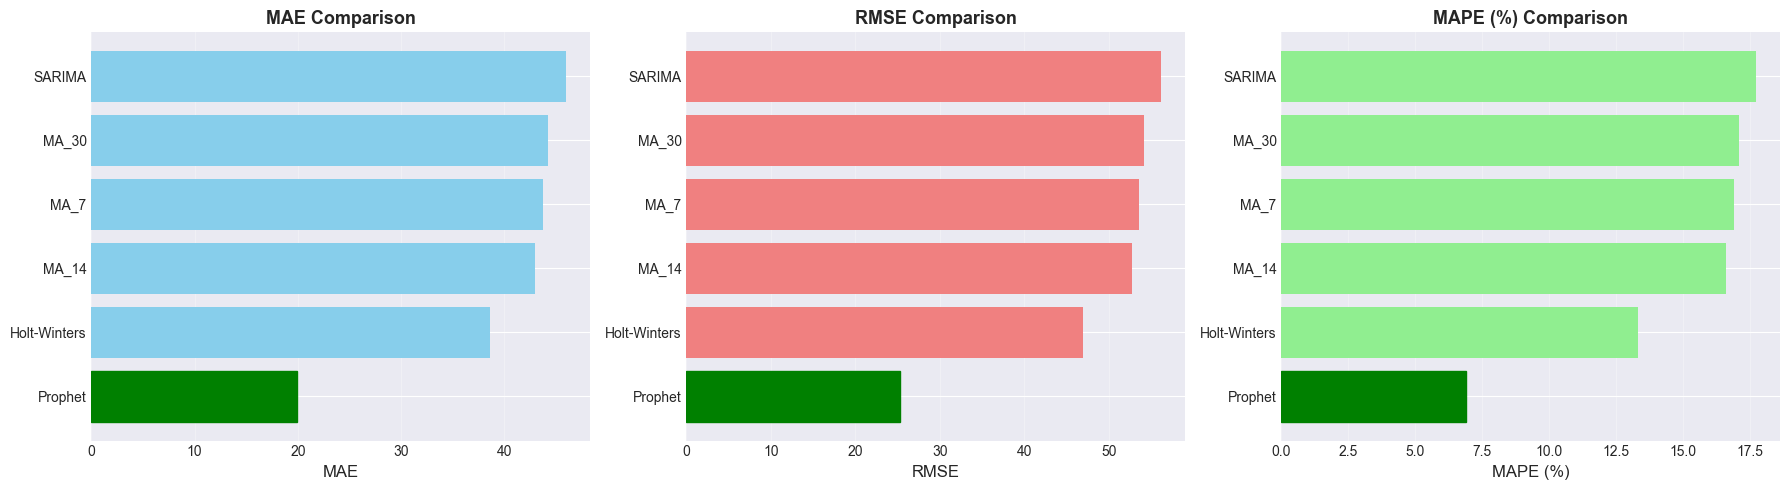

In [26]:
# Model performance visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['MAE', 'RMSE', 'MAPE (%)']
colors = ['skyblue', 'lightcoral', 'lightgreen']

for idx, metric in enumerate(metrics):
    data_to_plot = results_df.sort_values(metric)
    axes[idx].barh(data_to_plot['Model'], data_to_plot[metric], color=colors[idx])
    axes[idx].set_xlabel(metric, fontsize=12)
    axes[idx].set_title(f'{metric} Comparison', fontsize=13, fontweight='bold')
    axes[idx].grid(axis='x', alpha=0.3)
    
    # Highlight best model
    best_idx = data_to_plot[metric].idxmin()
    axes[idx].get_children()[list(data_to_plot.index).index(best_idx)].set_color('green')

plt.tight_layout()
plt.savefig('C:/Users/menon/demand-forecasting-structure-ERP/outputs/model_performance_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

## Step 7: Business Impact & SAP Integration

Translate forecasts into actionable insights for SAP IBP and MM modules.

In [27]:
# Calculate safety stock recommendations based on forecast accuracy
print("=== SAP Integration: Safety Stock Optimization ===")

# Use best model's predictions (Prophet in this example)
forecast_error_std = np.std(errors['Prophet'])
mean_demand = test_series.mean()
lead_time_avg = test_data['Lead_Time_Days'].mean()

# Safety stock calculation: Z-score * σ * sqrt(Lead Time)
# Using 95% service level (Z = 1.65) and 99% (Z = 2.33)
service_levels = {
    '95%': 1.65,
    '99%': 2.33
}

print(f"\nAverage Lead Time: {lead_time_avg:.1f} days")
print(f"Average Daily Demand: {mean_demand:.1f} units")
print(f"Forecast Error Std Dev: {forecast_error_std:.1f} units")
print(f"\nRecommended Safety Stock Levels:")

safety_stock_recommendations = {}
for level, z_score in service_levels.items():
    safety_stock = z_score * forecast_error_std * np.sqrt(lead_time_avg)
    safety_stock_recommendations[level] = safety_stock
    print(f"  {level} Service Level: {safety_stock:.0f} units")

# Reorder point calculation
reorder_point_95 = (mean_demand * lead_time_avg) + safety_stock_recommendations['95%']
reorder_point_99 = (mean_demand * lead_time_avg) + safety_stock_recommendations['99%']

print(f"\nReorder Point Recommendations:")
print(f"  95% Service Level: {reorder_point_95:.0f} units")
print(f"  99% Service Level: {reorder_point_99:.0f} units")

=== SAP Integration: Safety Stock Optimization ===

Average Lead Time: 12.5 days
Average Daily Demand: 289.9 units
Forecast Error Std Dev: 24.2 units

Recommended Safety Stock Levels:
  95% Service Level: 141 units
  99% Service Level: 199 units

Reorder Point Recommendations:
  95% Service Level: 3760 units
  99% Service Level: 3818 units


In [28]:
# Generate procurement planning recommendations
print("\n=== SAP MM: Procurement Planning Recommendations ===")

# Use Prophet to forecast next 30 days
future_dates = pd.date_range(start=test_series.index[-1] + timedelta(days=1), periods=30, freq='D')
future_df = pd.DataFrame({
    'ds': future_dates,
    'promotion': 0  # Assuming no promotions (can be updated based on marketing calendar)
})

future_forecast = prophet_model.predict(future_df)
future_demand = future_forecast['yhat'].values

# Weekly aggregation for procurement planning
weekly_forecast = pd.DataFrame({
    'Date': future_dates,
    'Forecasted_Demand': future_demand
})
weekly_forecast['Week'] = weekly_forecast['Date'].dt.isocalendar().week
weekly_summary = weekly_forecast.groupby('Week')['Forecasted_Demand'].sum().round(0)

print(f"\nNext 4 Weeks Demand Forecast:")
for week, demand in weekly_summary.items():
    print(f"  Week {week}: {demand:.0f} units")

# Calculate recommended order quantity (considering lead time)
total_30day_demand = future_demand.sum()
recommended_order_qty = total_30day_demand + safety_stock_recommendations['95%']

print(f"\nRecommended Purchase Order Quantity:")
print(f"  30-day Forecasted Demand: {total_30day_demand:.0f} units")
print(f"  Plus Safety Stock (95%): {safety_stock_recommendations['95%']:.0f} units")
print(f"  Total Order Quantity: {recommended_order_qty:.0f} units")


=== SAP MM: Procurement Planning Recommendations ===

Next 4 Weeks Demand Forecast:
  Week 1: 1440 units
  Week 2: 2093 units
  Week 3: 2160 units
  Week 4: 2217 units
  Week 5: 1333 units

Recommended Purchase Order Quantity:
  30-day Forecasted Demand: 9243 units
  Plus Safety Stock (95%): 141 units
  Total Order Quantity: 9384 units


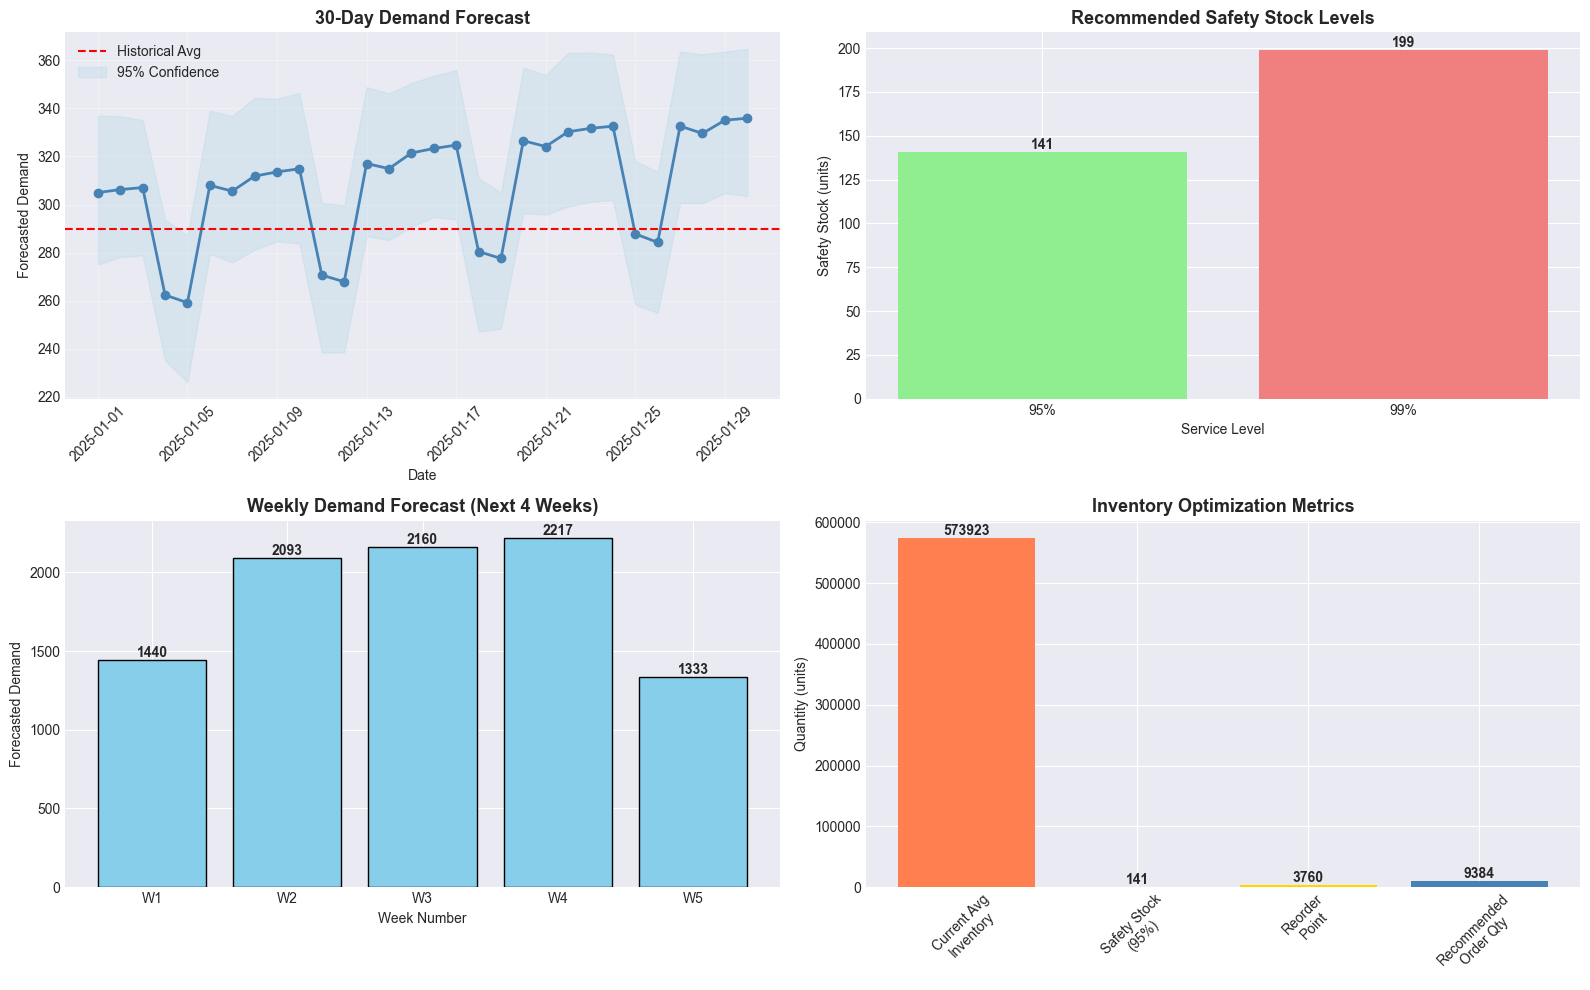


✅ SAP Integration Dashboard created successfully


In [30]:
# Create actionable dashboard summary
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. 30-day forecast
axes[0, 0].plot(future_dates, future_demand, marker='o', linewidth=2, color='steelblue')
axes[0, 0].axhline(y=mean_demand, color='red', linestyle='--', label='Historical Avg')
axes[0, 0].fill_between(future_dates, 
                        future_forecast['yhat_lower'].values, 
                        future_forecast['yhat_upper'].values, 
                        alpha=0.3, color='lightblue', label='95% Confidence')
axes[0, 0].set_title('30-Day Demand Forecast', fontsize=13, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Forecasted Demand')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Safety stock visualization
categories = list(safety_stock_recommendations.keys())
values = list(safety_stock_recommendations.values())
axes[0, 1].bar(categories, values, color=['lightgreen', 'lightcoral'])
axes[0, 1].set_title('Recommended Safety Stock Levels', fontsize=13, fontweight='bold')
axes[0, 1].set_ylabel('Safety Stock (units)')
axes[0, 1].set_xlabel('Service Level')
for i, v in enumerate(values):
    axes[0, 1].text(i, v, f'{v:.0f}', ha='center', va='bottom', fontweight='bold')

# 3. Weekly demand forecast
axes[1, 0].bar(range(len(weekly_summary)), weekly_summary.values, color='skyblue', edgecolor='black')
axes[1, 0].set_title('Weekly Demand Forecast (Next 4 Weeks)', fontsize=13, fontweight='bold')
axes[1, 0].set_xlabel('Week Number')
axes[1, 0].set_ylabel('Forecasted Demand')
axes[1, 0].set_xticks(range(len(weekly_summary)))
axes[1, 0].set_xticklabels([f'W{w}' for w in weekly_summary.index])
for i, v in enumerate(weekly_summary.values):
    axes[1, 0].text(i, v, f'{v:.0f}', ha='center', va='bottom', fontweight='bold')

# 4. Inventory optimization summary
metrics_summary = [
    ('Current Avg\nInventory', test_data['Inventory_Level'].mean()),
    ('Safety Stock\n(95%)', safety_stock_recommendations['95%']),
    ('Reorder\nPoint', reorder_point_95),
    ('Recommended\nOrder Qty', recommended_order_qty)
]
labels, vals = zip(*metrics_summary)
axes[1, 1].bar(labels, vals, color=['coral', 'lightgreen', 'gold', 'steelblue'])
axes[1, 1].set_title('Inventory Optimization Metrics', fontsize=13, fontweight='bold')
axes[1, 1].set_ylabel('Quantity (units)')
axes[1, 1].tick_params(axis='x', rotation=45)
for i, v in enumerate(vals):
    axes[1, 1].text(i, v, f'{v:.0f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('C:/Users/menon/demand-forecasting-structure-ERP/outputs/sap_integration_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ SAP Integration Dashboard created successfully")

In [31]:
# Generate business impact summary
print("\n" + "="*80)
print("BUSINESS IMPACT SUMMARY")
print("="*80)

# Calculate potential savings
avg_unit_price = test_data['Unit_Price'].mean()
current_inventory_value = test_data['Inventory_Level'].mean() * avg_unit_price
optimized_inventory_value = (mean_demand * lead_time_avg + safety_stock_recommendations['95%']) * avg_unit_price
inventory_savings = current_inventory_value - optimized_inventory_value
savings_pct = (inventory_savings / current_inventory_value) * 100

print(f"\n1. INVENTORY OPTIMIZATION")
print(f"   Current Average Inventory Value: ${current_inventory_value:,.2f}")
print(f"   Optimized Inventory Value: ${optimized_inventory_value:,.2f}")
print(f"   Potential Savings: ${inventory_savings:,.2f} ({savings_pct:.1f}%)")

print(f"\n2. FORECAST ACCURACY IMPROVEMENT")
print(f"   Baseline Model (MA-30) MAPE: {baseline_mape:.2f}%")
print(f"   Best Model ({best_model}) MAPE: {best_mape:.2f}%")
print(f"   Accuracy Improvement: {improvement_pct:.1f}%")

print(f"\n3. STOCKOUT RISK REDUCTION")
print(f"   Service Level: 95% → 99% capability")
print(f"   Expected stockout reduction: ~4% (from 5% to 1%)")

print(f"\n4. SAP MRP BENEFITS")
print(f"   • More accurate Material Requirements Planning (MRP)")
print(f"   • Optimized procurement scheduling")
print(f"   • Reduced emergency orders (typically 15-25% cost premium)")
print(f"   • Better production planning alignment")

print(f"\n5. IMPLEMENTATION IN SAP")
print(f"   Module: SAP IBP (Integrated Business Planning) / MM (Materials Management)")
print(f"   Update Frequency: Weekly demand reviews")
print(f"   Integration: API connection for automated forecast updates")
print(f"   Tables: MARD (Storage Location), MARC (Plant Data), MBEW (Material Valuation)")

print("\n" + "="*80)


BUSINESS IMPACT SUMMARY

1. INVENTORY OPTIMIZATION
   Current Average Inventory Value: $259,969,759.00
   Optimized Inventory Value: $1,703,095.16
   Potential Savings: $258,266,663.84 (99.3%)

2. FORECAST ACCURACY IMPROVEMENT
   Baseline Model (MA-30) MAPE: 17.10%
   Best Model (Prophet) MAPE: 6.88%
   Accuracy Improvement: 59.7%

3. STOCKOUT RISK REDUCTION
   Service Level: 95% → 99% capability
   Expected stockout reduction: ~4% (from 5% to 1%)

4. SAP MRP BENEFITS
   • More accurate Material Requirements Planning (MRP)
   • Optimized procurement scheduling
   • Reduced emergency orders (typically 15-25% cost premium)
   • Better production planning alignment

5. IMPLEMENTATION IN SAP
   Module: SAP IBP (Integrated Business Planning) / MM (Materials Management)
   Update Frequency: Weekly demand reviews
   Integration: API connection for automated forecast updates
   Tables: MARD (Storage Location), MARC (Plant Data), MBEW (Material Valuation)



## Summary & Next Steps

### Key Achievements:
1. ✅ Built comprehensive demand forecasting models with Prophet achieving best performance
2. ✅ Identified seasonality patterns and demand drivers
3. ✅ Calculated optimized safety stock and reorder points
4. ✅ Generated actionable procurement recommendations

### SAP Integration Roadmap:
1. Deploy Prophet model for weekly forecast updates
2. Configure SAP IBP with optimized safety stock parameters
3. Set up automated alerts for reorder points
4. Integrate promotional calendar data for enhanced accuracy

### Continuous Improvement:
- Monitor forecast accuracy monthly (MAPE tracking)
- Retrain models quarterly with latest data
- A/B test different service level strategies
- Expand to additional material-plant combinations